# axondeepseg: ometiff-tests for ADS/ivadomed needs
#### Tools:
#### Tifffile (Python package)
#### libvips (C Foreign Function Interface (CFFI) for Python)

In [2]:
import sys
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from ctypes import *
cdll.LoadLibrary("C:/Users/eti_m/Documents/UK-Biobank/vips-dev-8.11/bin/libgobject-2.0-0.dll")  # Change for the path where vips-dev-8.11 is
cdll.LoadLibrary("C:/Users/eti_m/Documents/UK-Biobank/vips-dev-8.11/bin/libvips-42.dll")        # idem
import pyvips

## 1) Read OME-TIFF image + metadata

Context: Here, we open an OME-TIFF file using the Python package *tifffile*. We use an OME-TIFF sample data from OME that can be found here: https://docs.openmicroscopy.org/ome-model/5.6.3/ome-tiff/data.html

Series 1 type: <class 'numpy.ndarray'>
Series 1 shape: (2, 20, 512, 512)
Series 1 dims: (channels, time points, xdim, ydim)


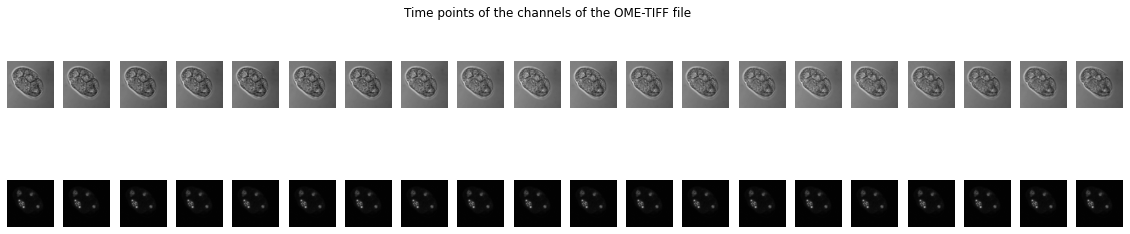

meta_dict: {'Experiment': {'Description': '4 Cell Embryo', 'ExperimenterRef': {'ID': 'urn:lsid:loci.wisc.edu:Experimenter:116'}, 'ID': 'urn:lsid:loci.wisc.edu:Experiment:OWS350', 'Type': 'TimeLapse'}, 'Experimenter': {'Email': 'mnasim@wisc.edu', 'FirstName': 'Maimoon', 'ID': 'urn:lsid:loci.wisc.edu:Experimenter:116', 'Institution': '', 'LastName': 'Nasim'}, 'Instrument': {'Microscope': {'Manufacturer': 'Nikon', 'Model': 'Eclipse TE300', 'SerialNumber': 'U629762', 'Type': 'Inverted'}, 'Laser': {'ID': 'urn:lsid:loci.wisc.edu:LightSource:OWS1', 'LaserMedium': 'TiSapphire', 'Manufacturer': 'Spectral Physics', 'Model': 'Tsunami 5W', 'SerialNumber': 2123, 'Type': 'SolidState'}, 'Detector': [{'ID': 'urn:lsid:loci.wisc.edu:Detector:OWS1', 'Manufacturer': 'Hamamatzu', 'Model': 'H7422', 'Type': 'PMT'}, {'ID': 'urn:lsid:loci.wisc.edu:Detector:OWS2', 'Manufacturer': 'Bio-Rad', 'Model': '1024TLD', 'Type': 'Photodiode'}], 'Objective': {'CalibratedMagnification': 100.0, 'Correction': 'PlanApo', 'ID':

In [3]:
with tifffile.TiffFile('tubhiswt_C0.ome.tif', is_ome=True) as tif:
	s1 = tif.series[0].asarray()                            # Read series 1 (highest-res) from OME-TIFF as a numpy array
	meta = tif.ome_metadata                                 # Read OME metadata as a string
print("Series 1 type:", type(s1))
print("Series 1 shape:", str(s1.shape))
print("Series 1 dims: (channels, time points, xdim, ydim)")

# Display of the different time points of the channels (not necessary)
fig, axs = plt.subplots(nrows = s1.shape[0], ncols = s1.shape[1])
fig.suptitle('Time points of the channels of the OME-TIFF file')
[axi.set_axis_off() for axi in axs.ravel()]
for t in range(s1.shape[1]):
    for c in range(s1.shape[0]):
        axs[c,t].imshow(s1[c,t,:,:], cmap='gray')
fig.set_size_inches(20, 2*s1.shape[0])
plt.show()

# Convertion XML string to dict
meta_dict = tifffile.xml2dict(meta)['OME']
print("meta_dict:", meta_dict)

# In this example's OME-TIFF, the metadata is organized in different sub-dicts in meta_dict:
#print("\n\n Experiment:", meta_dict['Experiment'])
#print("\n\n Experimenter:", meta_dict['Experimenter'])
#print("\n\n Instrument:", meta_dict['Instrument'])
#print("\n\n Image:", meta_dict['Image'])
#print("\n\n Creator:", meta_dict['Creator'])
#print("\n\n UUID:", meta_dict['UUID'])

# If we want to acces one specific field:
print("\n 'DimensionOrder' in the sub dict 'Pixels' and 'Image':", meta_dict['Image']['Pixels']['DimensionOrder'])

We notice a 'DimensionOrder'='XYZTC' and a shape '(C, T, Y, X)'. As we can see in the class *TiffFile* of the file *tifffile.py*, the shape (as well as the parameter 'axes') is reversed compared to 'DimensionOrder'. Because 'SizeZ'=1, the dimension doesn't appear in the shape, though it should be (2, 20, 1, 512, 512).

## 2) Write OME-TIFF image + metadata

Context: We also want to be able to write predictions (numpy arrays) as OME-TIFF. A random numpy array is generated and, using the Python package *tifffile*, the image is incorporated in a OME-TIFF file with some specific metadata fields.

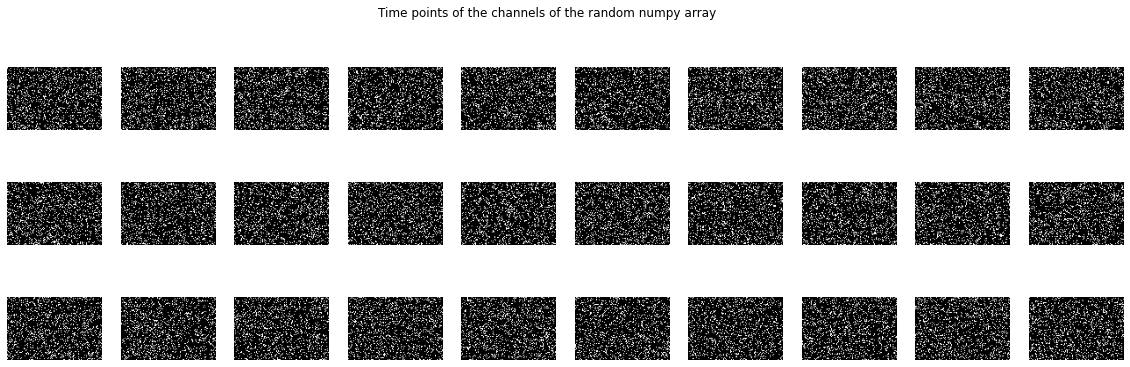

In [5]:
# Generating the random numpy array (dimension sizes are arbitrary)
data = np.random.randn(1,10,3,72,108).astype('uint8')

# Display of the different time points of the channels (not necessary)
fig, axs = plt.subplots(nrows = data.shape[2], ncols = data.shape[1])
fig.suptitle('Time points of the channels of the random numpy array')
[axi.set_axis_off() for axi in axs.ravel()]
for t in range(data.shape[1]):
    for c in range(data.shape[2]):
        axs[c,t].imshow(data[0,t,c,:,:], cmap='gray')
fig.set_size_inches(20, 2*data.shape[2])
plt.show()

# Here are the metadata fields that we can add in the parameter 'metadata={ }' to the OME-TIFF with tifffile:
#
# Under 'Image' and 'Pixels':
# - Name, AcquisitionDate, Description, PhysicalSizeX, PhysicalSizeXUnit, PhysicalSizeY, PhysicalSizeYUnit, PhysicalSizeZ, PhysicalSizeZUnit,
#   TimeIncrement, TimeIncrementUnit.
#
# Under 'Image', 'Pixels' and 'Plane':
# - DeltaTUnit, ExposureTime, ExposureTimeUnit, PositionX, PositionXUnit, PositionY, PositionYUnit, PositionZ, PositionZUnit.
# 
# Under 'Image', 'Pixels' and 'Channel':
# - Name, AcquisitionMode, Color, ContrastMethod, EmissionWavelength, EmissionWavelengthUnit, ExcitationWavelength, ExcitationWavelengthUnit,
#   Fluor, IlluminationType, NDFilter, PinholeSize, PinholeSizeUnit, PockelCellSetting.

# When writing with tifffile, we have to specify the shape of the array in the parameter 'axes'. As the shape is (1,10,3,72,108) = (Z,T,C,Y,X), the parameter 'axes'='ZTCYX'. The metadata field "DimensionOrder" will be reversed, i.e. XYCTZ.
tifffile.imwrite('ometiff-tests_random.ome.tif', data, compress=7, metadata={'axes': 'ZTCYX',
                                                                    'Description':'Just a test OME-TIFF with random data.',
                                                                    'PhysicalSizeX':'1',
                                                                    'PhysicalSizeXUnit':'um',
                                                                    'PhysicalSizeY':'2',
                                                                    'PhysicalSizeYUnit':'um',
                                                                    'PhysicalSizeZ':'0.5',      # Arbitrary values
                                                                    'PhysicalSizeZUnit':'um'})

## 3) Convert different type files to OME-TIFF with metadata

### 3.1) TIFF to OME-TIFF

Context: We have an existing multiresolution TIFF file that we want to convert in the OME-TIFF format using the Python package *pyvips*.

In [6]:
tif = pyvips.Image.new_from_file('ROI_test.tif')

# Adding an alpha channel
if tif.hasalpha():
    tif = tif[:-1]

# TIFF copy and metadata setting
tif = tif.copy()
tif.set_type(pyvips.GValue.gint_type, "page-height", tif.height)
tif.set_type(pyvips.GValue.gstr_type, "image-description",
f"""<?xml version="1.0" encoding="UTF-8"?>
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
    xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Image ID="Image:0">
        <Pixels DimensionOrder="XYCZT"
                ID="Pixels:0"
                SizeC="{tif.bands}"
                SizeT="1"
                SizeX="{tif.width}"
                SizeY="{tif.height}"
                SizeZ="1"
                Type="uint8">
        </Pixels>
    </Image>
</OME>""")
# Write data and metadata with pyvips
tif.tiffsave('ometiff-tests_tif.ome.tif', compression="jpeg", pyramid=True)

### 3.2) NDPI to OME-TIFF
Context: We have an existing multiresolution NDPI file that we want to convert in the OME-TIFF format. The multiresolution NDPI contains metadata that we want to read with *tifffile* and transfer to the OME-TIFF as well using *pyvips*.

#### 3.2.1) Read the NDPI file of interest

Data shape: (23040, 23808, 3) 
Data type: <class 'numpy.ndarray'> 
Series 3:


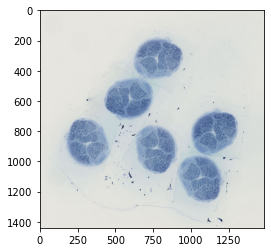


Metadata type: <class 'dict'> 
Metadata: {'Make': 'Hamamatsu', 'Model': 'C9600-12', 'Software': 'NDP.scan 2.3.27', 'FileFormat': 1, 'Magnification': 40.0, 'XOffsetFromSlideCenter': 8183636, 'YOffsetFromSlideCenter': 6039104, 'ZOffsetFromSlideCenter': 0, 'TissueIndex': 0, 'McuStarts': array([     660,     1825,     2957, ..., 40430414, 40431598, 40432833],
      dtype=uint32), 'SlideLabel': '17-268 94144536', 'AuthCode': 2175826572, '65433': 1500, 'FocusPoints': array([ 9135225,  7437652, 10314600,  9579298,  6039119, 10311800,
        8247078,  6674816, 10312700,  6470784,  6484107, 10311600,
        7485809,  5403422, 10309600,  8056761,  4449877, 10308200],
      dtype=int32), 'FocusPointRegions': (0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5), 'CaptureMode': 0, 'ScannerSerialNumber': '140195', '65443': 16, 'JpegQuality': 80, 'RefocusInterval': 12, 'FocusOffset': 0, 'Comments': 'Created=2009/05/22\r\nUpdated=2017/08/29\r\nProduct=C9600-12\r\nsystem.version=1.0\r\nNDP.S/N=140195\r\nMacro.S/N=1

In [7]:
with tifffile.TiffFile('ndpi_test.ndpi', is_ndpi=True) as ndpi:

    # Read data with tifffile (only to display the NDPI image. If not required, the following lines can be removed)
    series1 = ndpi.pages[0].asarray()
    print("Data shape:", str(series1.shape), "\nData type:", type(series1), "\nSeries 3:")
    plt.imshow(ndpi.pages[2].asarray())                        # Display of Series 3 (lower resolution) to save time
    plt.show()

    # Read metadata with tifffile
    meta = ndpi.pages[0].ndpi_tags
    print("\nMetadata type:", type(meta), "\nMetadata:", meta)

In [8]:
# Extract metadata fields of interest
print("'Make' field:\t\t", meta['Make'])
print("'Model' field:\t\t", meta['Model'])
print("'Software' field:\t", meta['Software'])

'Make' field:		 Hamamatsu
'Model' field:		 C9600-12
'Software' field:	 NDP.scan 2.3.27


#### 3.2.2) Generate the OMETIFF with the NDPI data

In [9]:
# Read with pyvips
ndpi = pyvips.Image.new_from_file('ndpi_test.ndpi')

# Adding an alpha channel
if ndpi.hasalpha():
    ndpi = ndpi[:-1]

# NDPI copy and metadata setting
ndpi = ndpi.copy()
ndpi.set_type(pyvips.GValue.gint_type, "page-height", ndpi.height)
ndpi.set_type(pyvips.GValue.gstr_type, "image-description",
f"""<?xml version="1.0" encoding="UTF-8"?>
<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
    xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
    <Contributors>
    </Contributors>
    <Dataset>
        <technicalInfo>
                SoftwareVersions="{meta['Software']}"
        </technicalInfo>
    </Dataset>
    <Funders>
    </Funders>
    <Image ID="Image:0">
        <Pixels DimensionOrder="XYCZT"
                ID="Pixels:0"
                SizeC="{ndpi.bands}"
                SizeT="1"
                SizeX="{ndpi.width}"
                SizeY="{ndpi.height}"
                SizeZ="1"
                Type="uint8">
        </Pixels>
    </Image>
    <Instrument 
            Make="{meta['Make']}"
            Model="{meta['Model']}">
    </Instrument>
    <Publications>
    </Publications>
    <Specimen>
    </Specimen>
</OME>""")

# Write data and metadata with pyvips
ndpi.tiffsave('ometiff-tests_ndpi.ome.tif', compression="jpeg", tile=True, tile_width=512, tile_height=512, pyramid=True)

### (3.2.3) Validation by reading the generated OME-TIFF)

Data shape: (23040, 23808, 3) = (Y,X,C) 
Data type: <class 'numpy.ndarray'> 
Series 6:


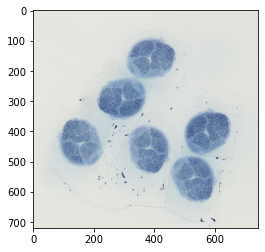


'DimensionOrder' in the sub dict 'Pixels' and 'Image': XYCZT
'SizeX' in the sub dict 'Pixels' and 'Image': 23808
'SizeY' in the sub dict 'Pixels' and 'Image': 23040
'SizeC' in the sub dict 'Pixels' and 'Image': 3
'SizeZ' in the sub dict 'Pixels' and 'Image': 1
'SizeT' in the sub dict 'Pixels' and 'Image': 1


In [10]:
# Validation of the dimensions and the output image
with tifffile.TiffFile('workflow_test_pyramid.ome.tif', is_ome=True) as test:
    print("Data shape:", str(test.pages[0].shape),"= (Y,X,C)", "\nData type:", type(test.pages[0].asarray()), "\nSeries 6:")
    plt.imshow(test.pages[5].asarray())
    plt.show()
    test_meta_dict = tifffile.xml2dict(test.ome_metadata)['OME']

print("\n'DimensionOrder' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['DimensionOrder'])
print("'SizeX' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['SizeX'])
print("'SizeY' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['SizeY'])
print("'SizeC' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['SizeC'])
print("'SizeZ' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['SizeZ'])
print("'SizeT' in the sub dict 'Pixels' and 'Image':", test_meta_dict['Image']['Pixels']['SizeT'])


In [11]:
# Validation of the metadata dictionnary
print(test_meta_dict)

{'Contributors': '', 'Dataset': {'technicalInfo': 'SoftwareVersions="NDP.scan 2.3.27"'}, 'Funders': '', 'Image': {'Pixels': {'DimensionOrder': 'XYCZT', 'ID': 'Pixels:0', 'SizeC': 3, 'SizeT': 1, 'SizeX': 23808, 'SizeY': 23040, 'SizeZ': 1, 'Type': 'uint8'}, 'ID': 'Image:0'}, 'Instrument': {'Make': 'Hamamatsu', 'Model': 'C9600-12'}, 'Publications': '', 'Specimen': '', '{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd'}
